In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *


2025-08-31 09:42:11.104220: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-31 09:42:11.182400: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-31 09:42:12.974563: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
!python -c "import numpy; print(numpy.__version__)"


1.26.4


In [2]:
pip install --force-reinstall "numpy<2.0"


  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow opencv-python scikit-image tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.4/620.4 MB 85.2 MB/s  0:00:04m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 102.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 150.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 170.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 148.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 138.3 MB/s  0:00:00
  Attempting uninstall: protobuf━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  1/16 [libclang]
    Found existing installation: protobuf 4.23.4━━━━━━━━━━━━━━  1/16 [libclang]
    Uninstalling protobuf-4.23.4:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  1/16 [libclang]
      Successfully uninstalled protobuf-4.23.4━━━━━━━━━━━━━━━━  1/16 [libclang]
  Attempting uninstall: tensorboard╸━━━━━━━━━━━━ 11/16 [gast]ypes]
    Found existing installation: tensorboard 2.15.1━━━━━━━━━━━ 11/16 [gast]
    Uninstalling tensorboard-2.15.1:╸━━━━━━━━━━━━ 11/16 [gast]
  

In [5]:
pip install kaggle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [kaggle]2m2/3 [kaggle]
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install kaggle

# make the hidden kaggle folder
!mkdir -p ~/.kaggle

# move your kaggle.json (must be uploaded first via file upload in Lightning UI)
!mv kaggle.json ~/.kaggle/

# fix permissions
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets list -s lgg-mri-segmentation


ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
mateuszbuda/lgg-mri-segmentation                                Brain MRI segmentation                                748584920  2019-05-02 21:32:45                 87581        976  0.875            
awsaf49/brats20-dataset-training-validation                     BraTS2020 Dataset (Training + Validation)            4468570941  2020-07-02 09:07:32.533000          66534        349  0.7647059        
aryashah2k/brain-tumor-segmentation-brats-2019                  Brain_Tumor_Segmentation_BraTS_2019                  2787193708  2021-03-09 05:16:23.077000          10631         63  1.0          

In [5]:
# Download the dataset
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

# Unzip into a local folder
!mkdir -p ./data
!unzip lgg-mri-segmentation.zip -d ./data


Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 95%|██████████████████████████████████████  | 680M/714M [00:00<00:00, 1.41GB/s]
100%|████████████████████████████████████████| 714M/714M [00:00<00:00, 1.41GB/s]
Archive:  lgg-mri-segmentation.zip
  inflating: ./data/kaggle_3m/README.md  
  inflating: ./data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif  
  inflating: ./data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif  
  inflating: ./data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif  
  inflating: ./data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif  
  inflating: ./data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif  
  inflating: ./data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif  
  inflating: ./data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif  
  inflating: ./data/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_

In [3]:
# Setting size parameters of images
im_width = 256
im_height = 256

In [4]:
from glob import glob
image_filenames_train = []

# creating a list of all files containing the word 'mask'
# in Local Machine
# mask_files = glob('../../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

# in Kaggle
mask_files = glob('data/lgg-mri-segmentation/kaggle_3m/*/*_mask.tif')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)

['data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_16.tif', 'data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_11.tif', 'data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6.tif', 'data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_9.tif', 'data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_3.tif', 'data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_19.tif', 'data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_14.tif', 'data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif', 'data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif', 'data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_10.tif']


3929

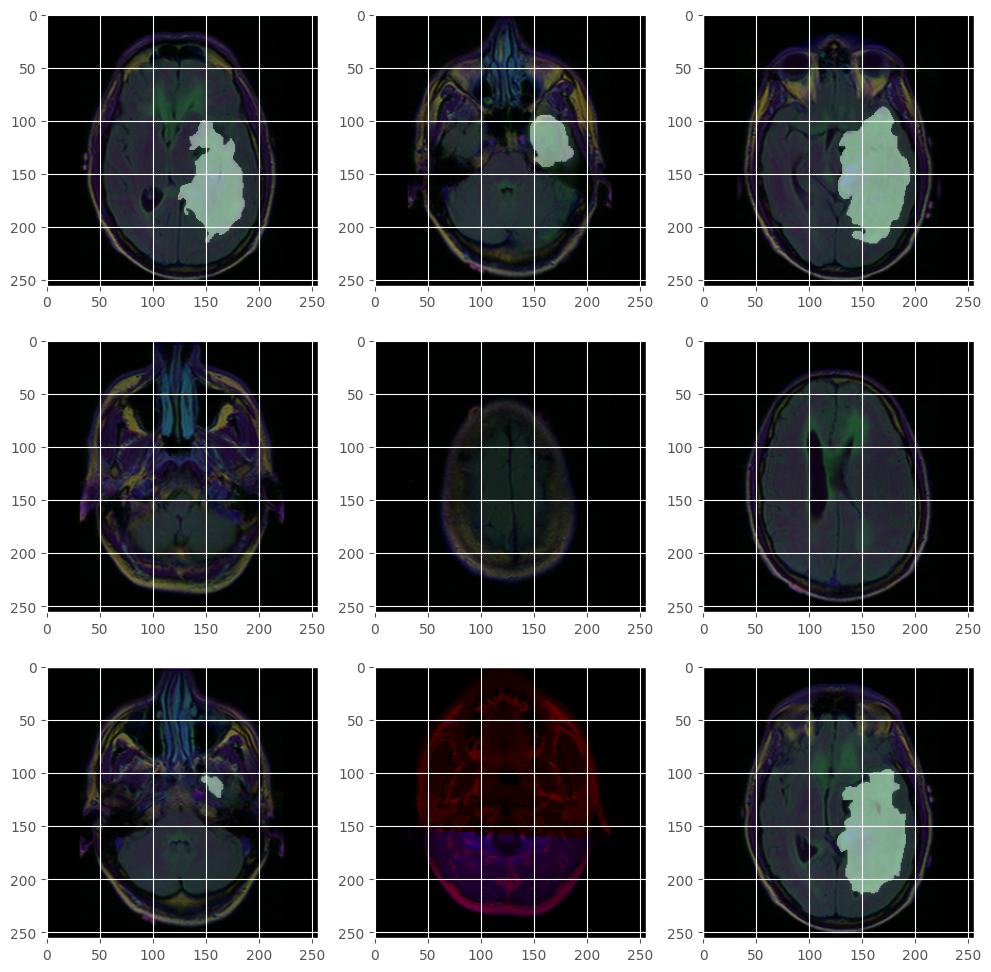

In [5]:
plot_from_img_path(3, 3 , image_filenames_train, mask_files )

In [6]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


In [7]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [8]:
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [12]:
EPOCHS = 200
BATCH_SIZE = 32
learning_rate = 1e-4
smooth=100

In [13]:
model = unet()
model.summary

<bound method Model.summary of <Functional name=functional_2, built=True>>

In [18]:
# Data augmentation parameters
train_generator_param = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generators
train_gen = train_generator(
    df_train,
    BATCH_SIZE,
    train_generator_param,
    target_size=(im_height, im_width)
)

test_gen = train_generator(
    df_val,
    BATCH_SIZE,
    dict(),
    target_size=(im_height, im_width)
)

# Model
model = unet(input_size=(im_height, im_width, 3))

# Optimizer (fixed)
opt = Adam(
    learning_rate=learning_rate,   # ✅ use learning_rate instead of lr
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,                 # ✅ keras default
    amsgrad=False
)

# Compile
model.compile(
    optimizer=opt,
    loss=dice_coefficients_loss,
    metrics=["binary_accuracy", iou, dice_coefficients]
)

# Callbacks
callbacks = [
    ModelCheckpoint('unet.keras', verbose=1, save_best_only=True)
]

# Training
history = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) // BATCH_SIZE,   # ✅ safer integer division
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=test_gen,
    validation_steps=len(df_val) // BATCH_SIZE
)


Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/200


2025-08-31 09:53:58.426574: I external/local_xla/xla/service/service.cc:163] XLA service 0x7affa0004300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-31 09:53:58.426611: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-08-31 09:53:58.688007: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-31 09:54:00.193842: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90701
2025-08-31 09:54:24.409678: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 20.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-31 09:54:29.895164: E external/local_xla/

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - binary_accuracy: 0.7907 - dice_coefficients: 0.0732 - iou: 0.0386 - loss: -0.0732Found 708 validated image filenames.
Found 708 validated image filenames.


2025-08-31 09:56:58.659343: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 20.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-08-31 09:57:02.428845: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-08-31 09:57:02.723697: E external/local_xla/xla/service


Epoch 1: val_loss improved from None to -0.02296, saving model to unet.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - binary_accuracy: 0.9015 - dice_coefficients: 0.1062 - iou: 0.0570 - loss: -0.1062 - val_binary_accuracy: 0.9887 - val_dice_coefficients: 0.0230 - val_iou: 0.0117 - val_loss: -0.0230
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - binary_accuracy: 0.9828 - dice_coefficients: 0.1759 - iou: 0.0975 - loss: -0.1751
Epoch 2: val_loss improved from -0.02296 to -0.02338, saving model to unet.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 131s 979ms/step - binary_accuracy: 0.9848 - dice_coefficients: 0.1835 - iou: 0.1024 - loss: -0.1834 - val_binary_accuracy: 0.9893 - val_dice_coefficients: 0.0234 - val_iou: 0.0120 - val_loss: -0.0234
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - binary_accuracy: 0.9859 - dice_coefficients: 0.2127 - iou: 0.1204 - loss: -0.2121
Epoch 3: val_loss improved from -0.02338 to -0.11042, saving model to unet.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/s

KeyboardInterrupt: 

In [2]:
from keras.models import load_model

model = load_model(
    "unet.keras",
    custom_objects={
        "dice_coefficients_loss": dice_coefficients_loss,
        "iou": iou,
        "dice_coefficients": dice_coefficients
    }
)


NameError: name 'dice_coefficients_loss' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


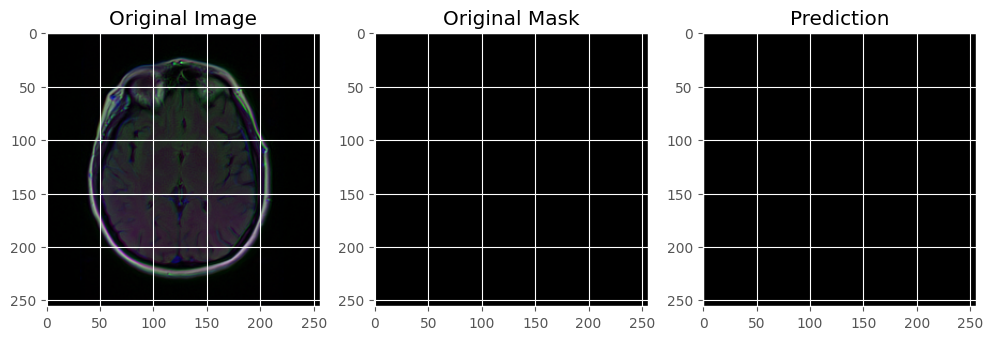

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


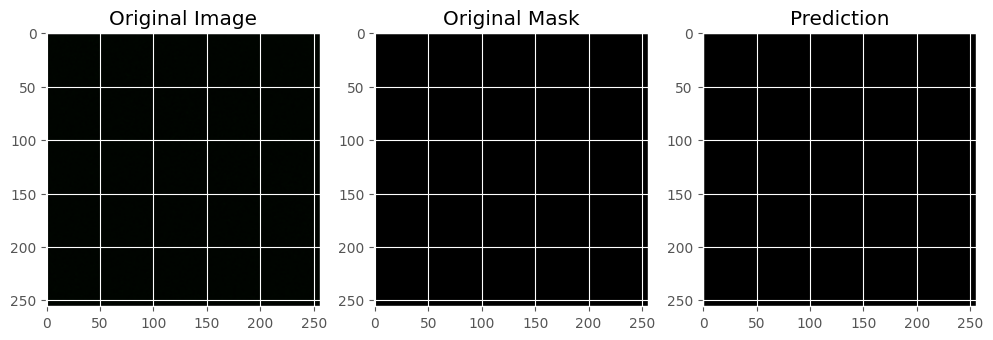

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


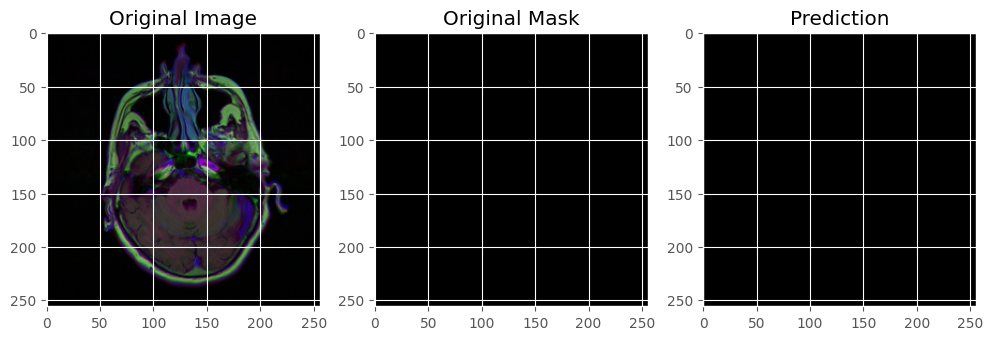

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


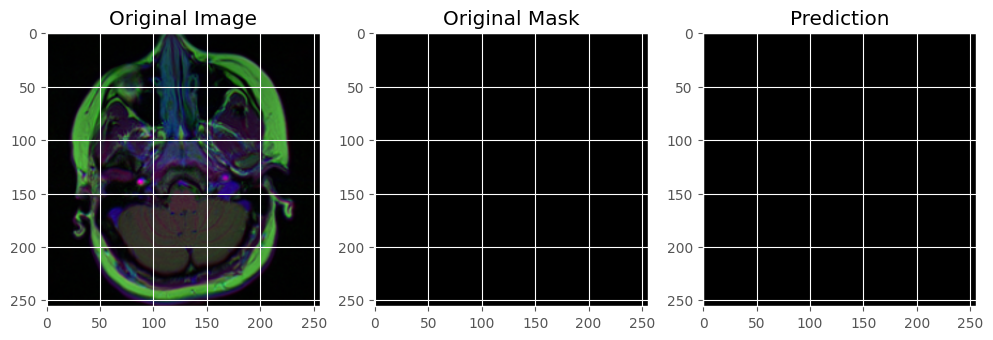

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


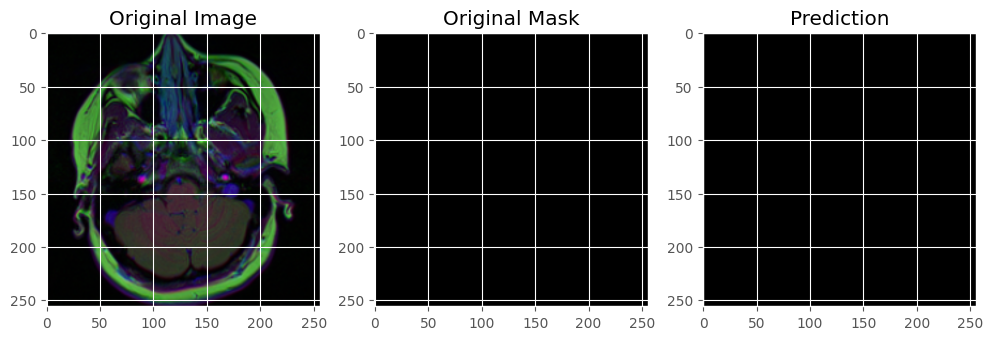

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


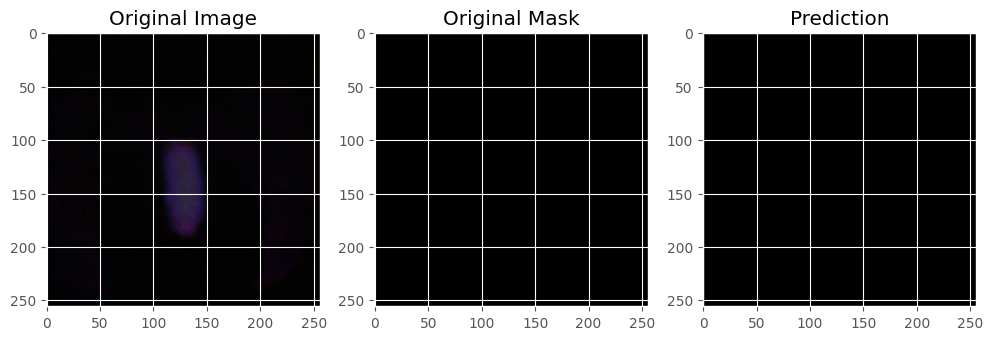

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


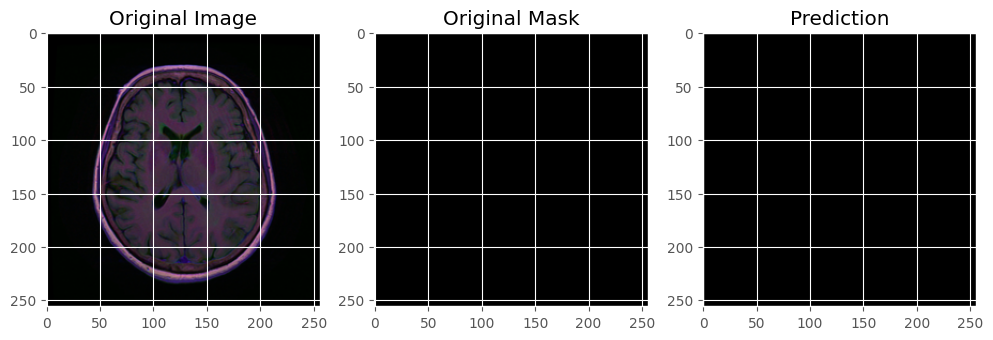

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


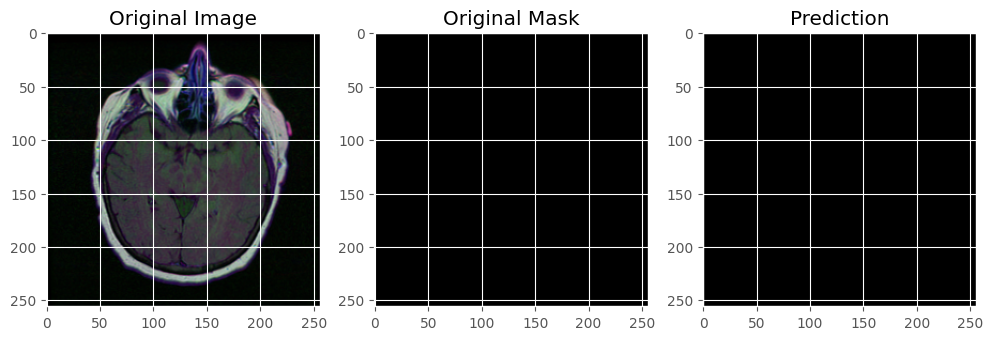

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


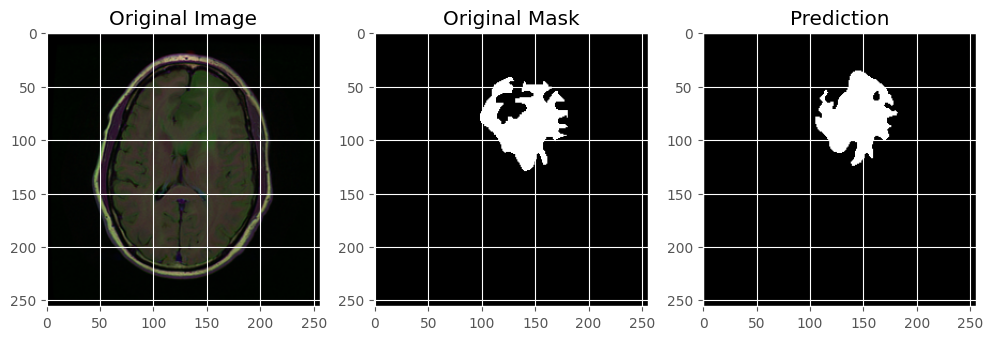

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


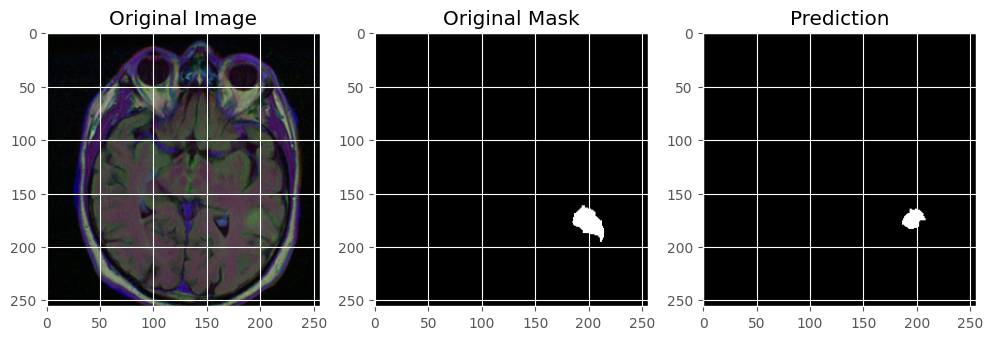

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


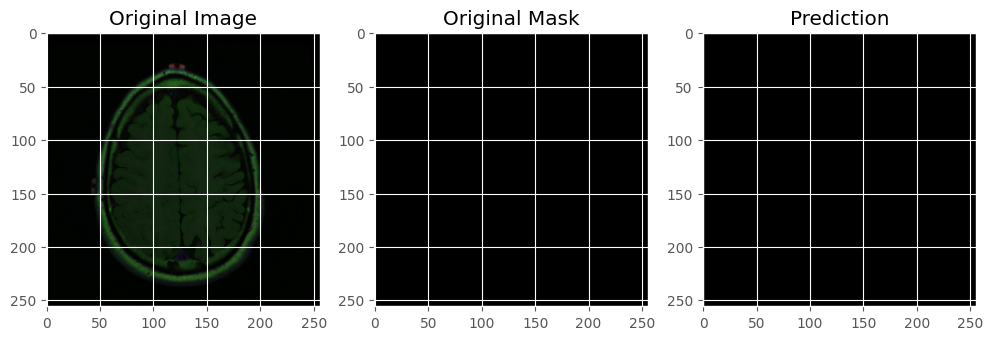

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


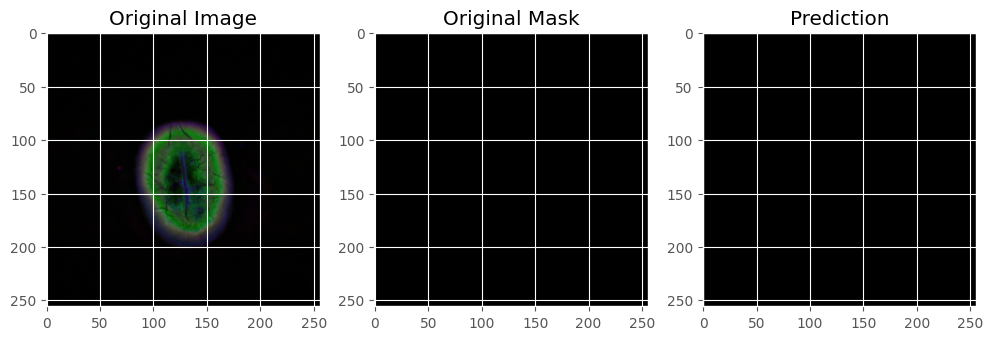

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


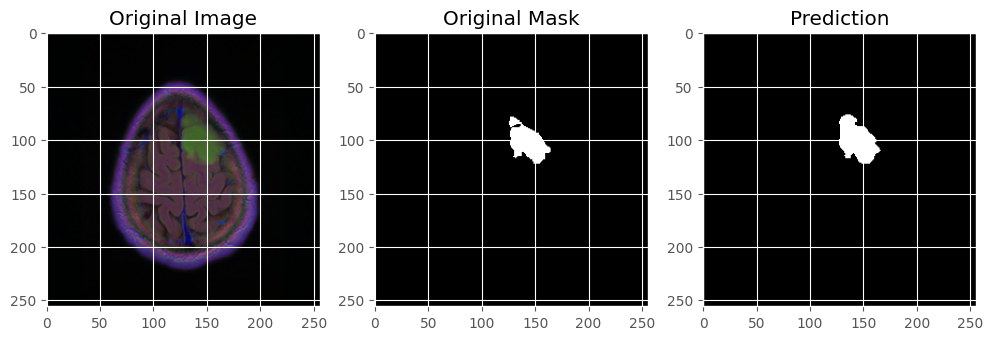

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


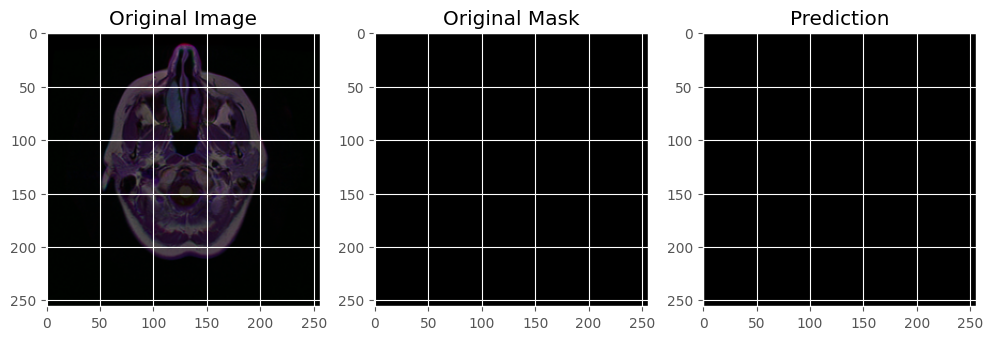

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


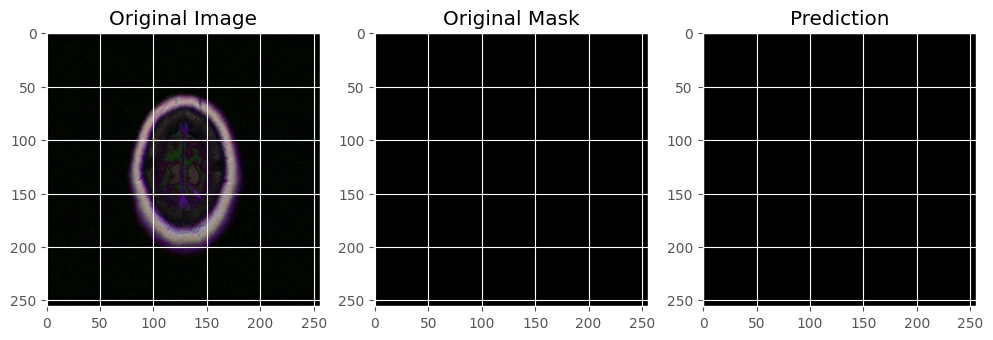

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


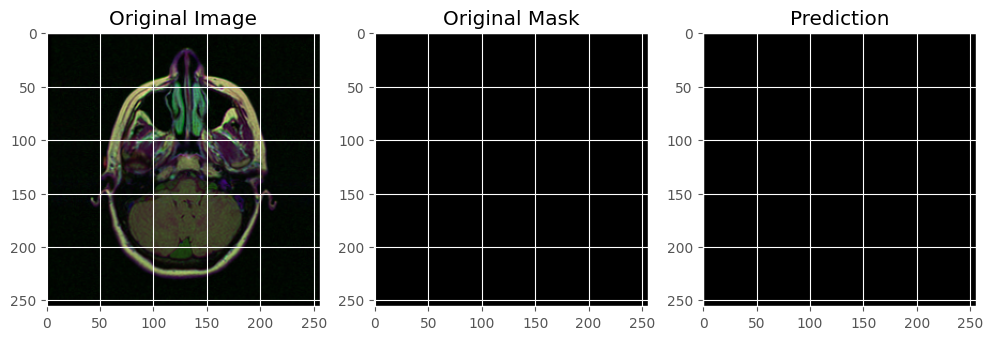

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


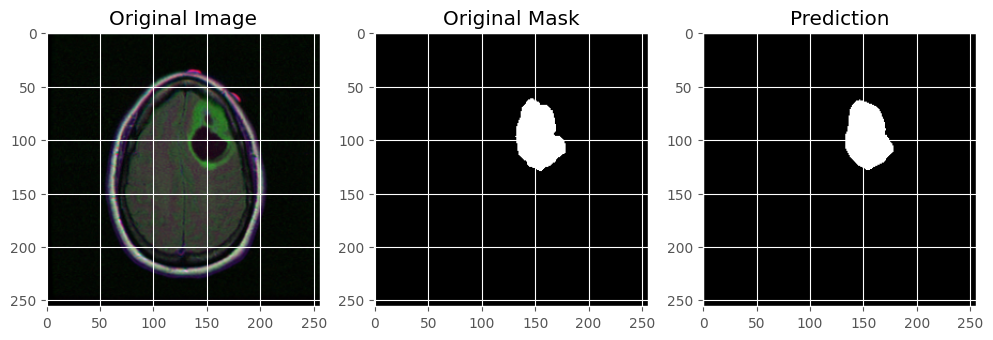

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


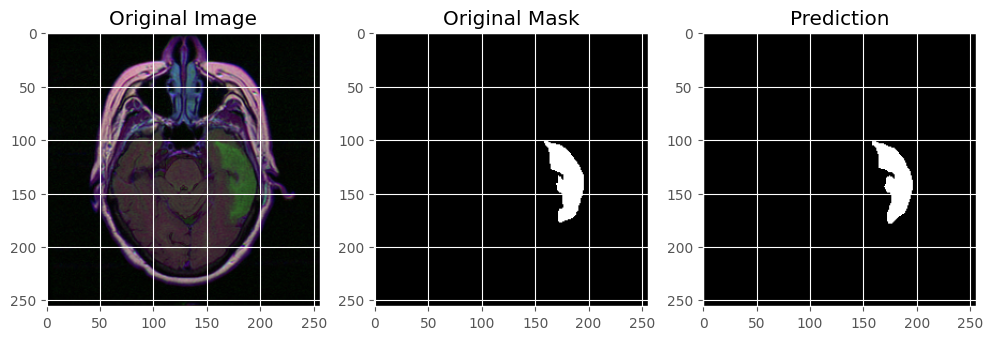

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


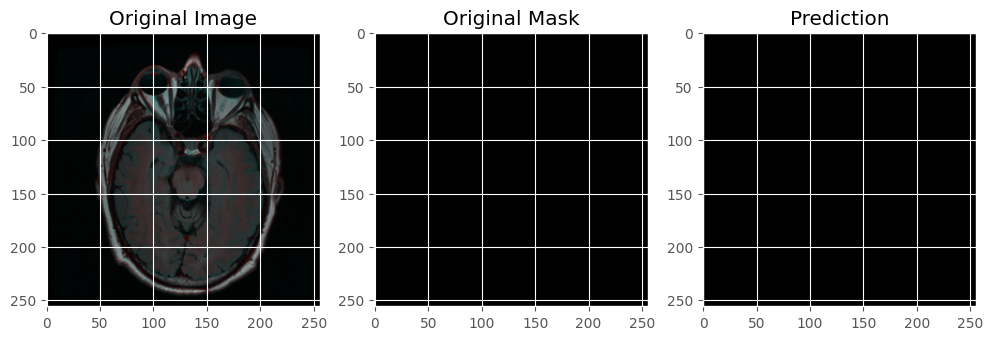

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


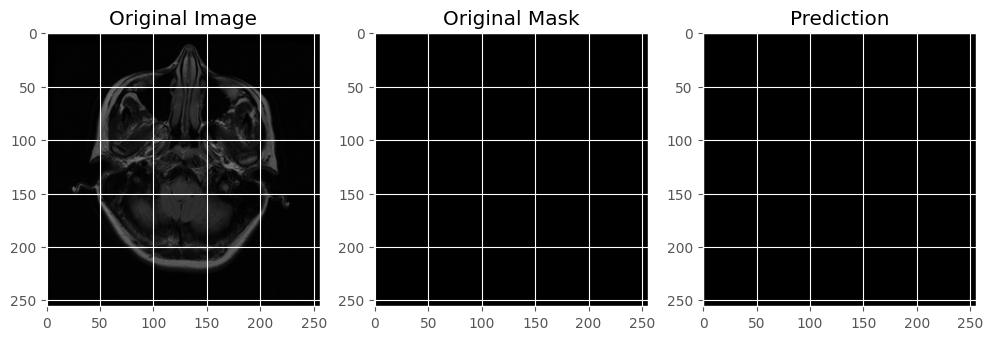

In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

for i in range(20):
    # pick random test sample
    index = np.random.randint(0, len(df_test.index))
    
    # read and preprocess image
    img_path = df_test['image_filenames_train'].iloc[index]  # adjust column name if different
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert BGR → RGB
    img = cv2.resize(img, (im_width, im_height))
    img_norm = img / 255.0
    img_input = img_norm[np.newaxis, :, :, :]  # (1, H, W, 3)

    # get prediction
    predicted_img = model.predict(img_input)[0]  # remove batch dim

    # read and preprocess mask
    mask_path = df_test['mask'].iloc[index]
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # mask is single-channel
    mask = cv2.resize(mask, (im_width, im_height))

    # plot results
    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Original Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_img.squeeze() > 0.5, cmap='gray')
    plt.title('Prediction')
    
    plt.show()


In [3]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# --- redefine custom metrics/loss (needed when loading) ---
def dice_coefficients(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coefficients_loss(y_true, y_pred):
    return 1 - dice_coefficients(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

# --- load your trained model ---
model = load_model("unet.keras",
                   custom_objects={
                       "dice_coefficients_loss": dice_coefficients_loss,
                       "dice_coefficients": dice_coefficients,
                       "iou": iou
                   })

# --- load & preprocess test image ---
image_path = "Te-gl_0014.jpg"  # your test MRI/CT image
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # assuming grayscale MRI
img = cv2.resize(img, (128, 128))  # must match training size
img = img.astype("float32") / 255.0
img = np.expand_dims(img, axis=(0, -1))  # shape = (1, H, W, 1)

# --- predict mask ---
pred_mask = model.predict(img)[0]  # shape = (H, W, 1)

# --- threshold for binary mask ---
mask = (pred_mask > 0.5).astype(np.uint8)

# save output mask
cv2.imwrite("predicted_mask.png", mask * 255)


I0000 00:00:1756819813.205922    3748 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:04.0, compute capability: 8.9


ValueError: Input 0 of layer "functional_7" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(1, 128, 128)

In [4]:
import numpy as np
import cv2
from tensorflow import keras

# --- load model ---
model = keras.models.load_model("unet.keras")

# --- load image (example: grayscale MRI scan) ---
img = cv2.imread("new_image.png", cv2.IMREAD_GRAYSCALE)

# Step 1: Resize to 256x256
img = cv2.resize(img, (256, 256))

# Step 2: Convert grayscale → 3 channels (RGB)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# Step 3: Normalize (if model trained with 0-1 scaling)
img = img.astype("float32") / 255.0

# Step 4: Add batch dimension
img = np.expand_dims(img, axis=0)   # shape = (1, 256, 256, 3)

# --- predict mask ---
pred_mask = model.predict(img)[0]  # shape = (256, 256, 1) or (256, 256, n_classes)

# --- threshold for binary segmentation (if single class) ---
mask = (pred_mask > 0.5).astype(np.uint8)


TypeError: Could not locate function 'dice_coefficients_loss'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'dice_coefficients_loss', 'registered_name': 'function'}

In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2

# --- define your custom functions (same as during training) ---
def dice_coefficients(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coefficients_loss(y_true, y_pred):
    return 1 - dice_coefficients(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# --- load model with custom objects ---
model = keras.models.load_model(
    "unet.keras",
    custom_objects={
        "dice_coefficients_loss": dice_coefficients_loss,
        "dice_coefficients": dice_coefficients,
        "iou": iou
    }
)

# --- load new image ---
img = cv2.imread("Te-gl_0014.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)   # make 3 channels
img = img.astype("float32") / 255.0
img = np.expand_dims(img, axis=0)             # shape = (1, 256, 256, 3)

# --- predict mask ---
pred_mask = model.predict(img)[0]  # shape = (256, 256, 1)
mask = (pred_mask > 0.5).astype(np.uint8)


2025-09-02 13:34:09.572504: I external/local_xla/xla/service/service.cc:163] XLA service 0x717978006fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-02 13:34:09.572533: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-09-02 13:34:09.636271: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-02 13:34:09.896710: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90701


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1756820055.478483    5321 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


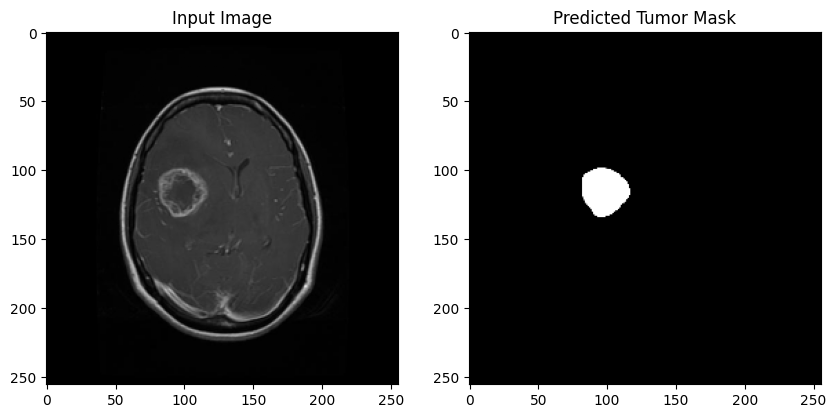

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(img.squeeze(), cmap="gray")

plt.subplot(1,2,2)
plt.title("Predicted Tumor Mask")
plt.imshow(pred_mask.squeeze(), cmap="gray")

plt.show()


In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2

# --- define your custom functions (same as during training) ---
def dice_coefficients(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coefficients_loss(y_true, y_pred):
    return 1 - dice_coefficients(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# --- load model with custom objects ---
model = keras.models.load_model(
    "unet.keras",
    custom_objects={
        "dice_coefficients_loss": dice_coefficients_loss,
        "dice_coefficients": dice_coefficients,
        "iou": iou
    }
)

# --- load new image ---
img = cv2.imread("Te-piTr_0003.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)   # make 3 channels
img = img.astype("float32") / 255.0
img = np.expand_dims(img, axis=0)             # shape = (1, 256, 256, 3)

# --- predict mask ---
pred_mask = model.predict(img)[0]  # shape = (256, 256, 1)
mask = (pred_mask > 0.5).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


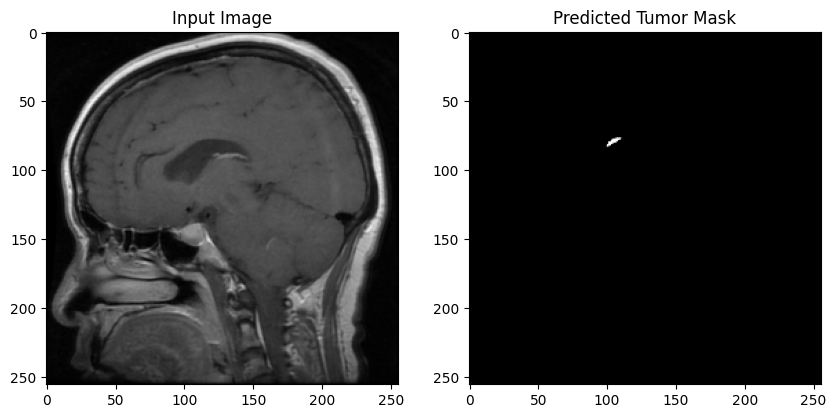

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(img.squeeze(), cmap="gray")

plt.subplot(1,2,2)
plt.title("Predicted Tumor Mask")
plt.imshow(pred_mask.squeeze(), cmap="gray")

plt.show()


In [12]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2

# --- define your custom functions (same as during training) ---
def dice_coefficients(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coefficients_loss(y_true, y_pred):
    return 1 - dice_coefficients(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# --- load model with custom objects ---
model = keras.models.load_model(
    "unet.keras",
    custom_objects={
        "dice_coefficients_loss": dice_coefficients_loss,
        "dice_coefficients": dice_coefficients,
        "iou": iou
    }
)

# --- load new image ---
img = cv2.imread("Te-no_0022.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)   # make 3 channels
img = img.astype("float32") / 255.0
img = np.expand_dims(img, axis=0)             # shape = (1, 256, 256, 3)

# --- predict mask ---
pred_mask = model.predict(img)[0]  # shape = (256, 256, 1)
mask = (pred_mask > 0.5).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


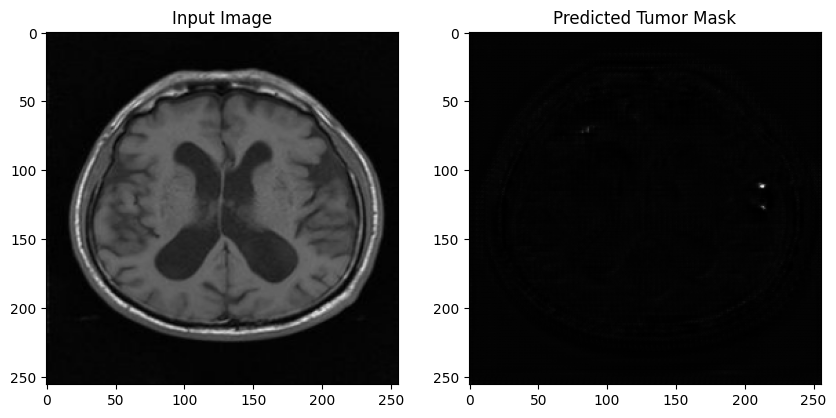

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(img.squeeze(), cmap="gray")

plt.subplot(1,2,2)
plt.title("Predicted Tumor Mask")
plt.imshow(pred_mask.squeeze(), cmap="gray")

plt.show()
